# ICESat-02 ATL03 Subset and Visualize

Authors: Sumant Jha (MSFC/USRA), Samuel Ayers (UAH), Alex Mandel (Development Seed), Aimee Barciauskas (Development Seed)

Date: March 6, 2023

Description: In this tutorial, we will search for ATL03 data within the NASA CMR. We will then read and visualize the data structure of a granule, create a subset and data frames, and visualize the photon heights.

## Run This Notebook
To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the ["Getting started with the MAAP"](https://docs.maap-project.org/en/latest/getting_started/getting_started.html) section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.

## About the Data

ATLAS/ICESat-2 L2A Global Geolocated Photon Data, Version 5

"This data set [ATL03] contains height above the WGS 84 ellipsoid (ITRF2014 reference frame), latitude, longitude, and time for all photons downlinked by the Advanced Topographic Laser Altimeter System (ATLAS) instrument on board the Ice, Cloud and land Elevation Satellite-2 (ICESat-2) observatory. The ATL03 product was designed to be a single source for all photon data and ancillary information needed by higher-level ATLAS/ICESat-2 products. As such, it also includes spacecraft and instrument parameters and ancillary data not explicitly required for ATL03." (Source: [ATL03 Dataset Landing Page](https://nsidc.org/data/atl03/versions/5))

## Additional Resources
- [ATL03 Version 5 User Guide](https://nsidc.org/sites/default/files/atl03-v005-userguide_1.pdf)
- [Earthdata Search](https://search.earthdata.nasa.gov/search?q=ATL03)

## Importing and Installing Packages

Required packages:

You will need to install the following required packages if not already present in your working environment: 
maap-py, 
pandas, 
geopandas, 
folium, 
shapely, 
h5glance, 
h5py

In [1]:
# ! pip install geopandas
# ! pip install folium
# ! pip install h5glance

In [2]:
# Import the MAAP package
from maap.maap import MAAP

# Invoke the MAAP constructor using the maap_host argument
maap = MAAP(maap_host='api.maap-project.org')

# Import pandas dataframe
import pandas as pd

# Import libraries needed for visualizing data spatial extent
import geopandas as gpd
import folium
from shapely.geometry import Polygon,Point

# Import H5glance to interactively explore H5 file in notebook
from h5glance import H5Glance

# Import H5py to read h5 file
import h5py

# Import os to create a new directory
import os

## Decide on a Subset of ATL03 Data
First, we will create a subset using a spatial extent and date range before visualizaing using folium. For this tutorial, we will focus on a very small area over Yosemite National Park and use a temporal range of one day.

In [3]:
# Create a variable for short name of ATL03 data
short_name = 'ATL03'

# Create Latitude, Longitude list.
lat_coords = [37.700057,37.700057,37.758166,37.758166,37.700057]
lon_coords = [-119.680359,-119.680359,-119.538910,-119.538910,-119.680359]

# Create bounding box
spatial_extent = [lon_coords[0],lat_coords[0],lon_coords[2],lat_coords[2]]

# Reformat bounding box to work with NASA CMR API
spatial_extent = ','.join(str(coords) for coords in spatial_extent)

#Provide date range. It is just 1 day. 
date_range = ['2021-02-02','2022-02-03']

# For folium purpose, provide the map center
map_center = [37.729139,-119.609670]

# Convert to AOI for visualizaton with folium
polygon_geom = Polygon(zip(lon_coords, lat_coords))

# Provide relevant Coordinate Reference System
crs = 'epsg:4326'

# Convert to Geodataframe and back to list in that specific reference system
AOI = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
AOI_bbox = AOI.bounds.iloc[0].to_list()

In [4]:
# Visualize the spatial extent using folium.
m = folium.Map(map_center, zoom_start=12, tiles='OpenStreetMap')
folium.GeoJson(AOI).add_to(m)
folium.LatLngPopup().add_to(m)
m

## Search for Granules
We will now search for granules in NASA's CMR given our spatial extent and date range, then print the number of granules available.

In [5]:
# Provide the name of cmr host to use with maap py
nasa_cmr_host = "cmr.earthdata.nasa.gov"
# Search granule using maap-py using subset criteria identified earlier.
data = maap.searchGranule(cmr_host=nasa_cmr_host,short_name = short_name, bounding_box = spatial_extent,temporal= date_range,limit=1000)
# Check to see if the granule search was successfull in finding data within spatial and temporal extent
print(len(data))

104


Let's create a new data directory and use maap-py's getData functon to extract the first H5 file. We will then print the name of the extracted file.

In [6]:
# set data directory
dataDir = "./data"

# check if directory exists -> if directory doesn't exist, directory is created
if not os.path.exists(dataDir):
    os.mkdir(dataDir)

# download and extract the resource
ice_data = data[0].getData(dataDir)
print(ice_data)

./data/ATL03_20210202191800_06231006_005_01.h5


## Read the H5 File

Let's read in the H5 file to understand the data structure. There are two ways to do this. We can just list keys and then go forward exploring each key one by one...

In [7]:
# Open the H5 file and list the keys
ice_file = h5py.File(ice_data,'r')
list(ice_file.keys())

['METADATA',
 'ancillary_data',
 'atlas_impulse_response',
 'ds_surf_type',
 'ds_xyz',
 'gt1l',
 'gt1r',
 'gt2l',
 'gt2r',
 'gt3l',
 'gt3r',
 'orbit_info',
 'quality_assessment']

... or use the h5glance package to interactively list various keys, sub-keys and variables.

H5Glance lists all the keys and sub-keys and allows for the copying of path variables on the fly, all from within the Jupyter Notebook. 
Note: In the web version of this notebook which is shown here, not all sub-fields will be listed. But they can be accessed when using a Jupyter Notebook running on ADE or local machines.

In [8]:
H5Glance(ice_file)

./data/ATL03_20210202191800_06231006_005_01.h5/ (47 attributes)
├METADATA	(9 children) (3 attributes)
├ancillary_data	(34 children) (2 attributes)
├atlas_impulse_response	(2 children) (1 attributes)
├ds_surf_type	[int32: 5] (12 attributes)
├ds_xyz	[int32: 3] (12 attributes)
├gt1l	(5 children) (7 attributes)
├gt1r	(5 children) (7 attributes)
├gt2l	(5 children) (7 attributes)
├gt2r	(5 children) (7 attributes)
├gt3l	(5 children) (7 attributes)
├gt3r	(5 children) (7 attributes)
├orbit_info	(7 children) (2 attributes)
└quality_assessment	(9 children) (1 attributes)

## Subset the Data by Required Columns

In this case, we will need Latitude, Longitude, Photon Height and Along Track Distance. We are using the copied path from the data tree generated by H5Glance above.

Use h5py to read file and variables from the copied path.

In [9]:
with h5py.File(ice_data,'r') as f:
    gt1l_lat = f['/gt1l/heights/lat_ph'][:]
    gt1l_lon = f['/gt1l/heights/lon_ph'][:]
    gt1l_height = f['/gt1l/heights/h_ph'][:]
    gt1l_dist_ph = f['/gt1l/heights/dist_ph_along'][:]

## Show the Subset Data in a Dataframe
1. By using the Pandas module:

In [10]:
# Write latitude, longitude, photon height and along track distance for gt1l to a dataframe
gt1l_df = pd.DataFrame({'Latitude': gt1l_lat, 'Longitude': gt1l_lon, 'Photon_Height': gt1l_height,'Along_track_distance':gt1l_dist_ph})
gt1l_df

,Latitude,Longitude,Photon_Height,Along_track_distance
0,59.482065,-115.906874,611.887878,16.894447
1,59.482065,-115.906877,580.084106,16.980614
2,59.482064,-115.906882,527.962097,17.122099
3,59.482063,-115.906885,491.036133,17.222527
4,59.482059,-115.906875,616.919922,17.593958
...,...,...,...,...
36561868,33.011390,-119.752303,69.065865,4.154013
36561869,33.011382,-119.752316,-16.501354,5.156162
36561870,33.011380,-119.752329,-108.562981,5.470425
36561871,33.011376,-119.752317,-17.947205,5.871534


2. By using the Geopandas module: 

Create geopandas dataframe with a column for point locations in the geometry column, and other relevant variables.

In [11]:
geometry = gpd.points_from_xy(gt1l_lon, gt1l_lat)
data = {'Latitude': gt1l_lat, 'Longitude': gt1l_lon, 'Photon_Height': gt1l_height,'Along_track_distance':gt1l_dist_ph}
gdf = gpd.GeoDataFrame(data,geometry=geometry, crs='EPSG:4326')

# View the resulting geopandas dataframe
print(gdf.head())

    Latitude   Longitude  Photon_Height  Along_track_distance  \
0  59.482065 -115.906874     611.887878             16.894447   
1  59.482065 -115.906877     580.084106             16.980614   
2  59.482064 -115.906882     527.962097             17.122099   
3  59.482063 -115.906885     491.036133             17.222527   
4  59.482059 -115.906875     616.919922             17.593958   

                      geometry  
0  POINT (-115.90687 59.48207)  
1  POINT (-115.90688 59.48206)  
2  POINT (-115.90688 59.48206)  
3  POINT (-115.90689 59.48206)  
4  POINT (-115.90687 59.48206)  


## Visualize Photon Heights
Finally, we'll visualize the photon heights with respect to along track distance for this H5 file using inputs from the geodataframe:

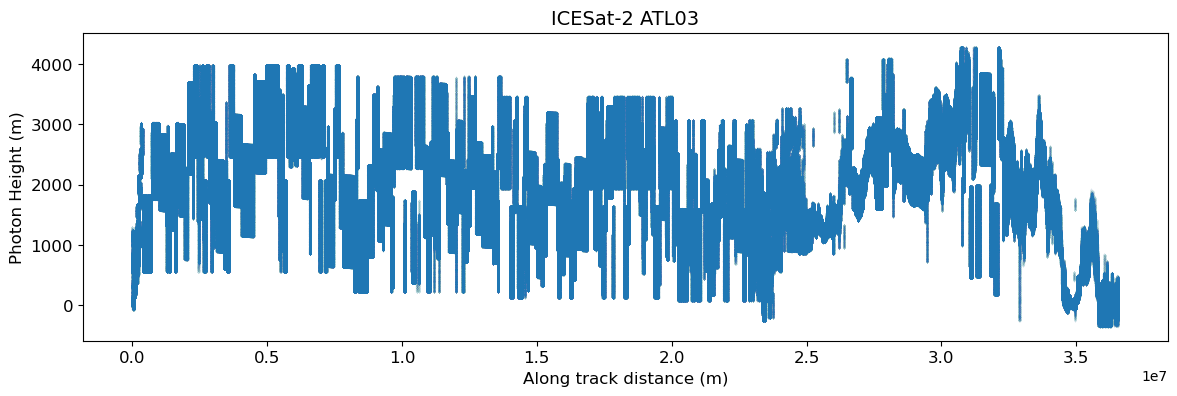

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 4))
gdf.Photon_Height.plot(ax=ax, ls='', marker='.', ms=0.01)
ax.set_xlabel('Along track distance (m)', fontsize=12);
ax.set_ylabel('Photon Height (m)', fontsize=12)
ax.set_title('ICESat-2 ATL03', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)